In [ ]:
pwd

In [ ]:
#import readdy
import boto3
import numpy as np
import argparse
from subcell_analysis.readdy import (
    ReaddyLoader,
    ReaddyPostProcessor,
)
from subcell_analysis.compression_workflow_runner import compression_metrics_workflow,  plot_metric, plot_metric_list
from subcell_analysis.compression_analysis import (
    COMPRESSIONMETRIC,
)
from subcell_analysis.cytosim.post_process_cytosim import create_dataframes_for_repeats
import pandas as pd

In [ ]:
save_folder = "../data/readdy_h5_files"

In [ ]:
file_name = "actin_compression_velocity_15_0.h5"
s3 = boto3.client('s3')
response = s3.download_file('readdy-working-bucket', 'outputs/actin_compression_velocity=15_0.h5', f'{save_folder}/{file_name}')

In [ ]:
h5_file_path = f'{save_folder}/{file_name}'

post_processor = ReaddyPostProcessor(
    ReaddyLoader(h5_file_path).trajectory(),
    box_size=600.0 * np.ones(3),
)
fiber_chain_ids = post_processor.linear_fiber_chain_ids(
    start_particle_phrases=["pointed"],
    other_particle_types=[
        "actin#",
        "actin#ATP_",
        "actin#mid_",
        "actin#mid_ATP_",
        "actin#fixed_",
        "actin#fixed_ATP_",
        "actin#mid_fixed_",
        "actin#mid_fixed_ATP_",
        "actin#barbed_",
        "actin#barbed_ATP_",
        "actin#fixed_barbed_",
        "actin#fixed_barbed_ATP_",
    ],
    polymer_number_range=5,
)
axis_positions, _ = post_processor.linear_fiber_axis_positions(
    fiber_chain_ids=fiber_chain_ids,
    ideal_positions=np.array(
        [
            [24.738, 20.881, 26.671],
            [27.609, 24.061, 27.598],
            [30.382, 21.190, 25.725],
        ]
    ),
    ideal_vector_to_axis=np.array(
        [-0.01056751, -1.47785105, -0.65833209],
    ),
)
fiber_points = post_processor.linear_fiber_control_points(
    axis_positions=axis_positions,
    segment_length=10.0,
)
print(fiber_points)


In [ ]:
fiber_points

In [ ]:
from subcell_analysis.compression_workflow_runner import compression_metrics_workflow,  plot_metric, plot_metric_list
from subcell_analysis.compression_analysis import (
    COMPRESSIONMETRIC,
)
from subcell_analysis.cytosim.post_process_cytosim import create_dataframes_for_repeats
import pandas as pd


In [ ]:
arr = np.array(fiber_points[0][0])
arr.shape


def array_to_dataframe(arr):
    # Reshape the array to remove the singleton dimensions
    arr = np.squeeze(arr)

    # Reshape the array to have dimensions (timepoints * 50, 3)
    reshaped_arr = arr.reshape(-1, 3)

    # Create a DataFrame with timepoint and fiber point as multi-index
    timepoints = np.repeat(range(arr.shape[0]), 50)
    fiber_points = np.tile(range(50), arr.shape[0])

    df = pd.DataFrame(reshaped_arr)
    df['time'] = timepoints
    df['id'] = fiber_points

    df.set_index(['time', 'id'], inplace=True)

    return df
df_points = array_to_dataframe(arr)
df_points.reset_index(inplace=True)
df_points.rename(columns= {0:'x', 1:'y', 2:'z'}, inplace=True)
single_timepoint = df_points[df_points['time'] == 0]
single_timepoint


In [ ]:
df_points

In [ ]:
df_points

df_points['time'].unique()
df_points.to_csv("../dataframes/readdy_processed_data.csv", index=False)
#df_points.to_csv("../dataframes/readdy_processed_data.csv")



In [ ]:
df_points = pd.read_csv("../dataframes/readdy_processed_data.csv")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Assuming you have a DataFrame named 'df_points' with columns 'time', 'id', 'x', 'y', and 'z'
# df_points = pd.DataFrame(...)  # Your data goes here

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get unique timestamps in the data
timestamps = df_points['time'].unique()

# Function to update the plot at each time step
def update_plot(time_step, ax=ax):
    ax.cla()  # Clear previous plot

    # Filter the data for the current timestamp
    data_at_time = df_points[df_points['time'] == timestamps[time_step]]

    # Plot the points at the current time step
    ax.scatter(data_at_time['x'], data_at_time['y'], data_at_time['z'], c='r', marker='o')

    # Set plot labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(f'Time: {timestamps[time_step]}')
    ax.set_xlim([-300, 300])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-10, 30])
    ax.set_aspect("equal")

# Create the animation
update_plot(-1) 

# If you want to save the animation to a file
# animation.save('3d_animation.mp4', writer='ffmpeg')
#animation.save('3d_animation_frames/frame_{:04d}.png', writer='pillow', fps=1)

# Show the plot (If you don't want to save it)
plt.show()


In [ ]:
%matplotlib inline

In [ ]:
plt.close("all")

In [ ]:
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
metrics = [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST]
df_points = compression_metrics_workflow(df_points, [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST])
df_points.columns

In [ ]:
for metric in metrics:
    fig, ax = plt.subplots()
    print(metric.value)
    metric_by_time = df_points.groupby(["time"])[metric.value].mean()
    ax.plot(metric_by_time, label=f"metric = {metric.value}")
    plt.legend()
    plt.show()

## Generating Outputs for All Readdy Simulations

In [ ]:
compression_velocities = [4.7, 15, 47, 150]
iterations = [0, 1, 2]  
empty_array = np.zeros((len(compression_velocities), len(iterations)))

Post Processing

In [ ]:
from pathlib import Path

In [ ]:
data_dir = Path("../data/readdy_h5_files")
data_dir.mkdir(exist_ok=True, parents=True)

In [ ]:

for index, velocity in enumerate(compression_velocities):
    for iteration in iterations:
        new_file_path = f'{data_dir}/readdy_actin_compression_velocity_{velocity}_{iteration}.h5'
        print(f"Downloading file: {new_file_path}")
        response = s3.download_file('readdy-working-bucket', f'outputs/actin_compression_velocity={velocity}_{iteration}.h5', new_file_path)


In [ ]:
fiber_points = np.empty((4, 3), dtype=object)

for index, velocity in enumerate(compression_velocities):
    for iteration in iterations:
        new_file_path = f'{data_dir}/actin_compression_velocity_{velocity}_{iteration}.h5'
        post_processor = ReaddyPostProcessor(
        ReaddyLoader(new_file_path).trajectory(),
        box_size=600.0 * np.ones(3),
        )
        fiber_chain_ids = post_processor.linear_fiber_chain_ids(
        start_particle_phrases=["pointed"],
        other_particle_types=[
            "actin#",
            "actin#ATP_",
            "actin#mid_",
            "actin#mid_ATP_",
            "actin#fixed_",
            "actin#fixed_ATP_",
            "actin#mid_fixed_",
            "actin#mid_fixed_ATP_",
            "actin#barbed_",
            "actin#barbed_ATP_",
            "actin#fixed_barbed_",
            "actin#fixed_barbed_ATP_",
        ],
        polymer_number_range=5,
        )
        axis_positions, _ = post_processor.linear_fiber_axis_positions(
            fiber_chain_ids=fiber_chain_ids,
            ideal_positions=np.array(
                [
                    [24.738, 20.881, 26.671],
                    [27.609, 24.061, 27.598],
                    [30.382, 21.190, 25.725],
                ]
            ),
            ideal_vector_to_axis=np.array(
                [-0.01056751, -1.47785105, -0.65833209],
            ),
        )
        fiber_points[index][iteration] = post_processor.linear_fiber_control_points(
            axis_positions=axis_positions,
            segment_length=10.0,
        )
     

Save processed fiber_points

In [ ]:
df_path = Path("../data/dataframes/")
df_path.mkdir(exist_ok=True, parents=True)

In [ ]:
for index, velocity in enumerate(compression_velocities):
    for iteration in iterations:
        print(index, iteration)
        if index == 1 and iteration == 2:  #  TODO: check why this is happening
            break
        arr = np.array(fiber_points[index][iteration])
        print(arr.shape)
        df_points = array_to_dataframe(arr)
        df_points.reset_index(inplace=True)
        df_points.rename(columns= {0:'xpos', 1:'ypos', 2:'zpos'}, inplace=True)
        df_points.to_csv(f"{df_path}/actin_compression_velocity_{velocity}.{iteration}.csv", index=False)
        

## Starting from Reading from CSV

In [ ]:
df_path = Path("../data/dataframes/")
df_path.mkdir(exist_ok=True, parents=True)

In [ ]:
processed_dataframes = np.empty((len(compression_velocities), len(iterations)), dtype = object)
for index, velocity in enumerate(compression_velocities):
    for iteration in iterations:
        if index == 1 and iteration == 2:
            break
        processed_dataframes[index][iteration] = pd.read_csv(f"{df_path}/readdy_actin_compression_velocity_{velocity}_repeat_{iteration}.csv")
        print(index, iteration, processed_dataframes[index][iteration].shape)
        

Calculate metrics for processed dataframes

In [ ]:
for index, velocity in enumerate(compression_velocities):
    for iteration in iterations:
        print(index, iteration)
        if (index == 1 and iteration == 2):
            break
        processed_dataframes[index][iteration] = compression_metrics_workflow(processed_dataframes[index][iteration], [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST])       

In [ ]:
processed_dataframes[0][1]

Plot calculated metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
figure_path = Path("../figures/readdy_metrics")
figure_path.mkdir(exist_ok=True, parents=True)

In [ ]:
plt.close("all")

NON_COPLANARITY
NON_COPLANARITY
NON_COPLANARITY
NON_COPLANARITY


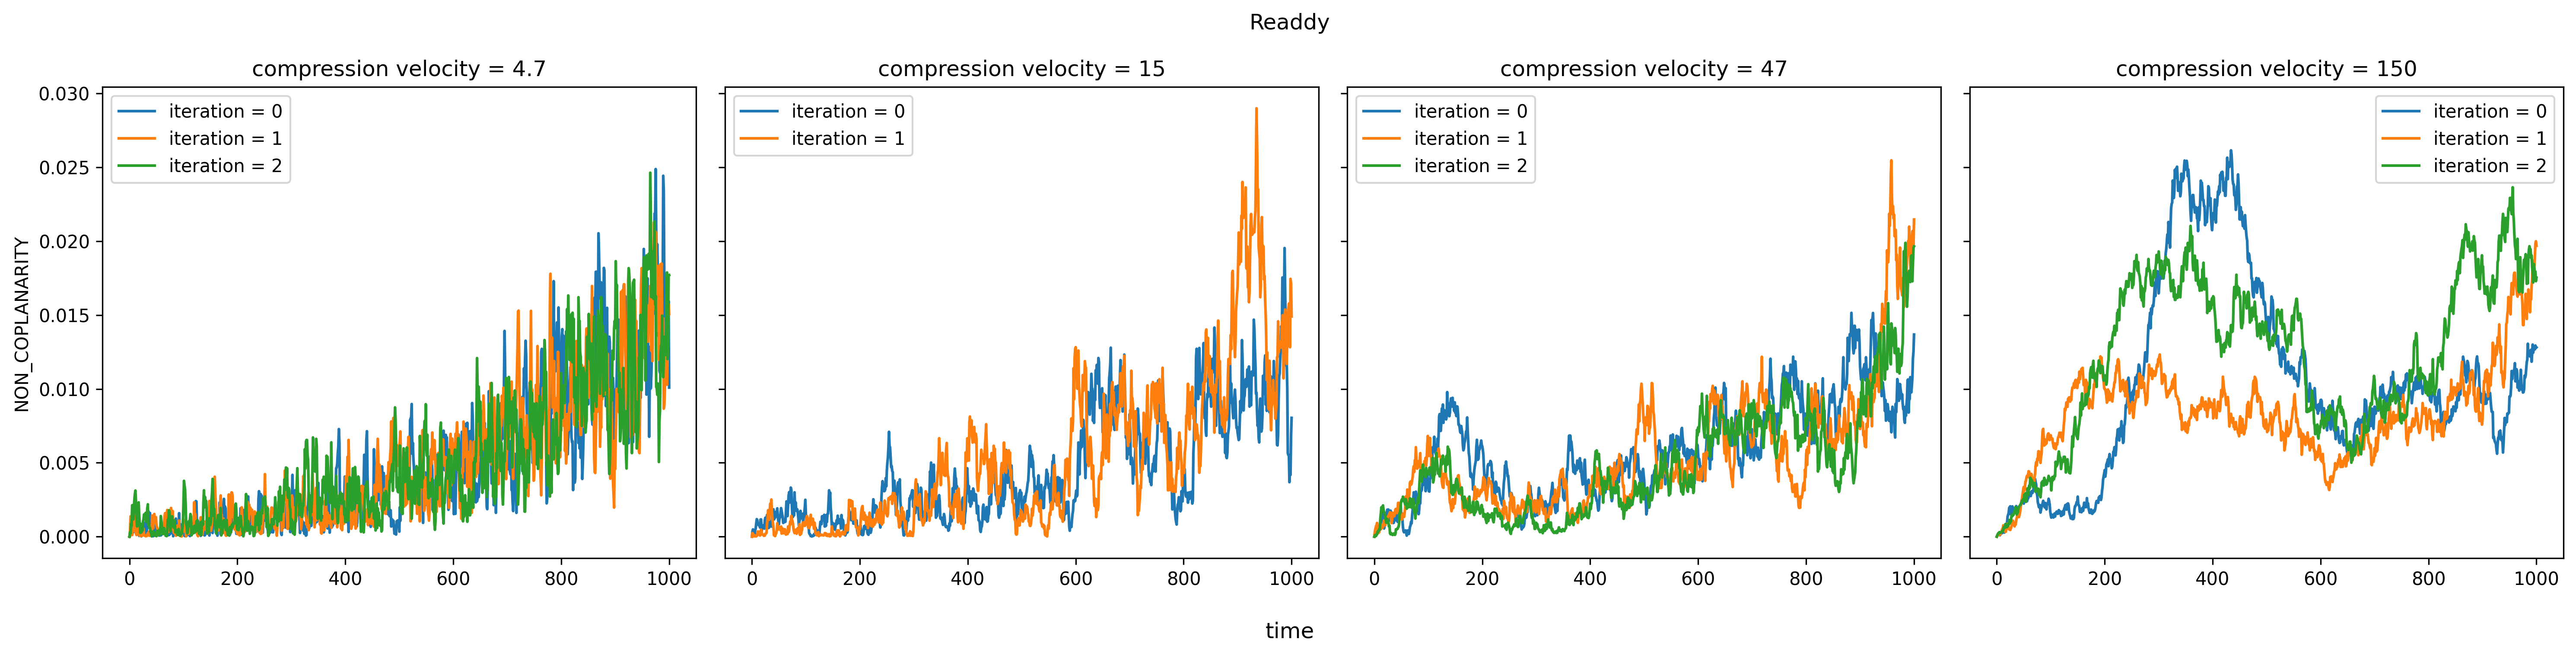

PEAK_ASYMMETRY
PEAK_ASYMMETRY
PEAK_ASYMMETRY
PEAK_ASYMMETRY


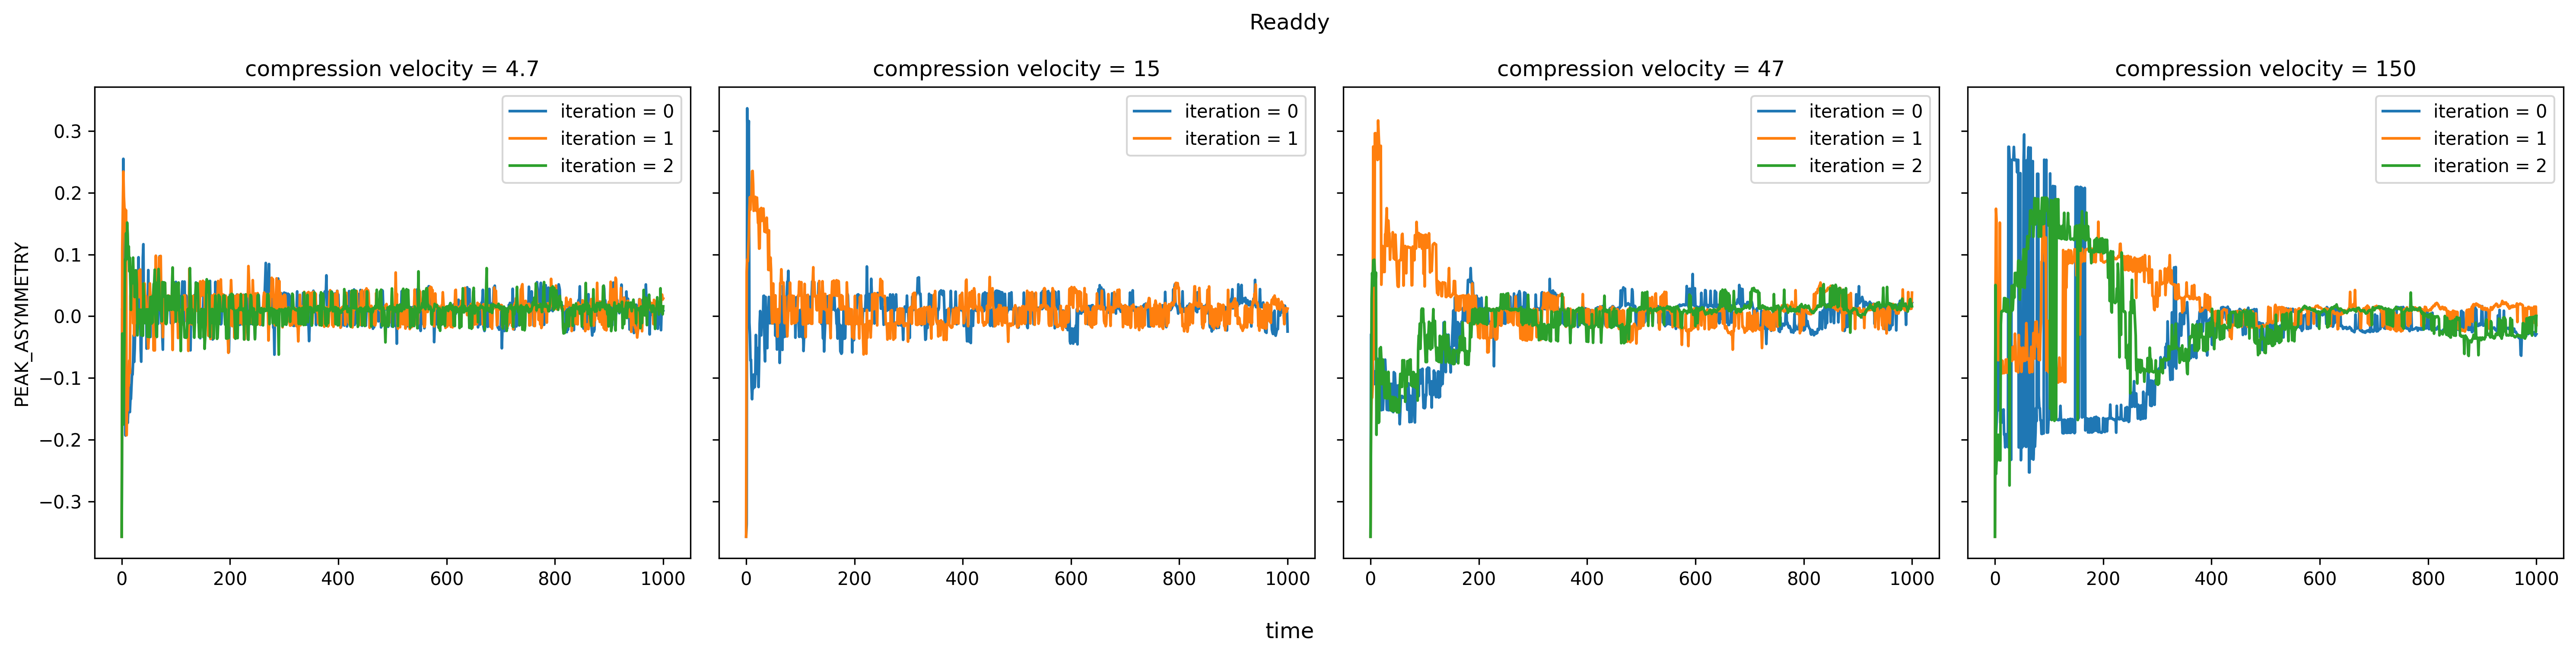

TOTAL_FIBER_TWIST
TOTAL_FIBER_TWIST
TOTAL_FIBER_TWIST
TOTAL_FIBER_TWIST


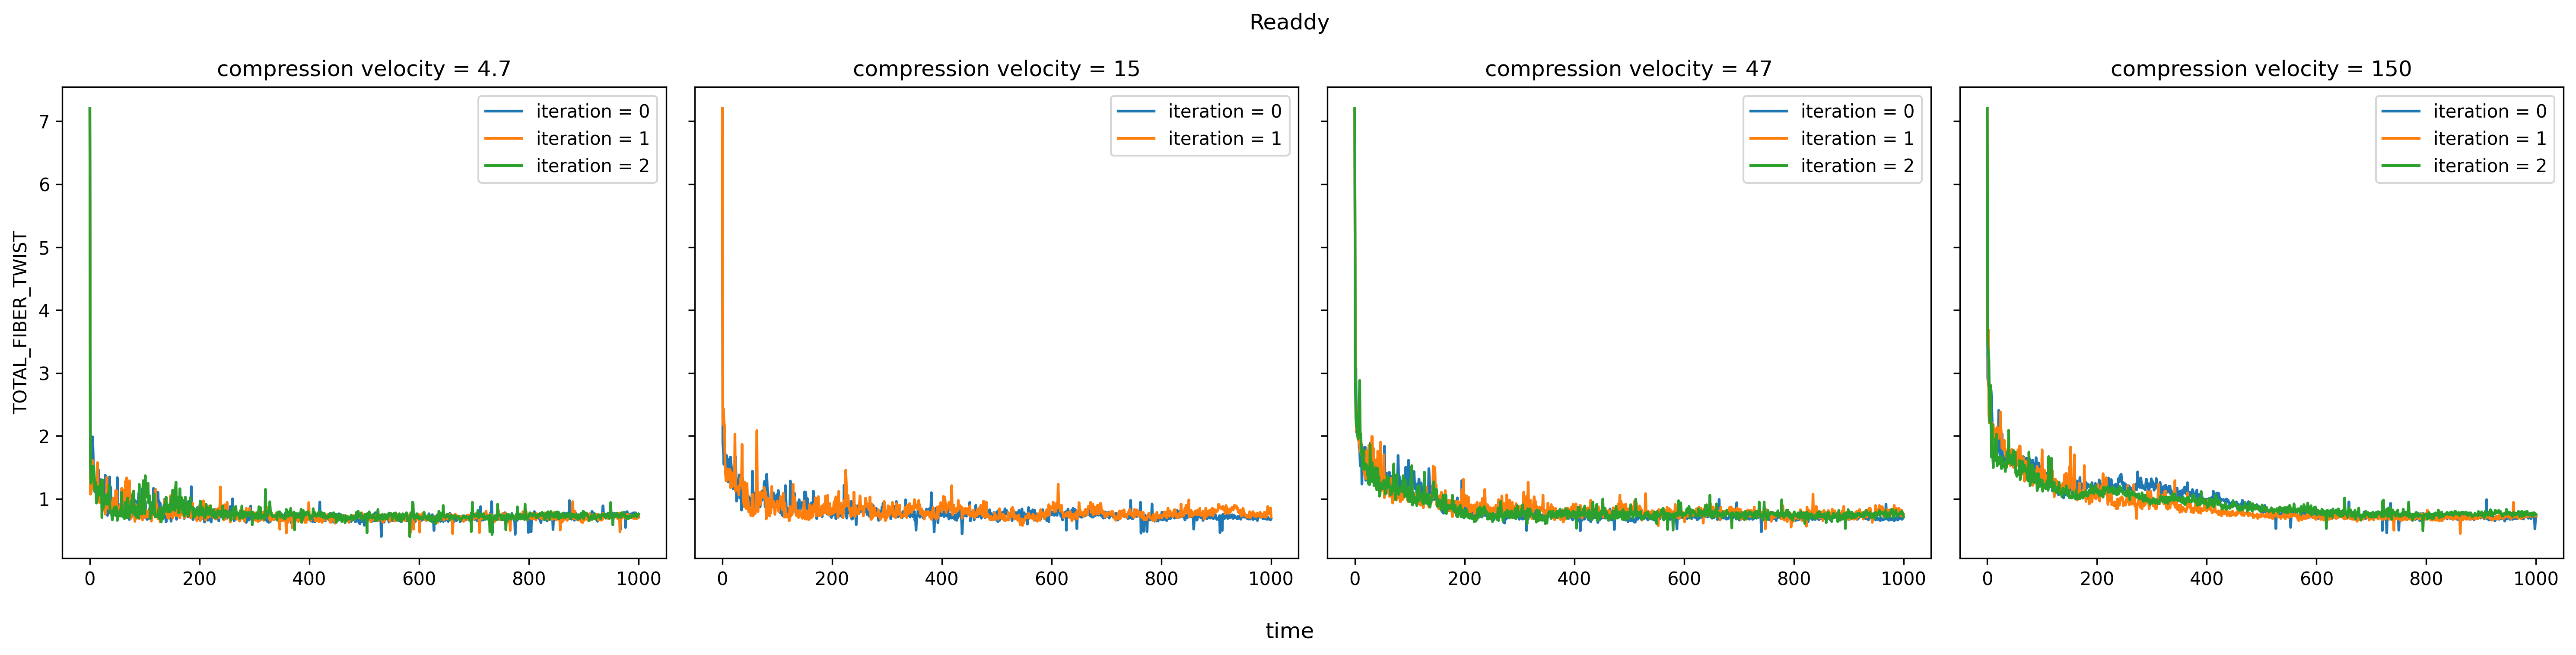

In [32]:
metrics =  [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST]
compression_velocities = [4.7, 15, 47, 150]
for metric in metrics:
    fig, axs = plt.subplots(1, len(compression_velocities), figsize=(len(compression_velocities) * 5, 5), dpi=300, sharey=True, sharex=True)
    for index, velocity in enumerate(compression_velocities):
        print(metric.value)
        for iteration in iterations:
            if (index == 1 and iteration == 2):
                continue
            metric_by_time = processed_dataframes[index][iteration].groupby(["time"])[metric.value].mean()
            axs[index].plot(metric_by_time, label=f"iteration = {iteration}")
        axs[index].set_title(f"compression velocity = {velocity}")
        axs[index].legend()
        if index == 0:
            axs[index].set_ylabel(metric.value)
    fig.suptitle(f"Readdy")
    fig.supxlabel("time")
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{figure_path}/actin_compression_all_velocities_{metric.value}.png")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Assuming you have a DataFrame named 'df_points' with columns 'time', 'id', 'x', 'y', and 'z'
# df_points = pd.DataFrame(...)  # Your data goes here

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get unique timestamps in the data
timestamps = processed_dataframes[0][0]['time'].unique()

# Function to update the plot at each time step
def update_plot(time_step, ax=ax):
    ax.cla()  # Clear previous plot

    # Filter the data for the current timestamp
    data_at_time = df_points[df_points['time'] == timestamps[time_step]]

    # Plot the points at the current time step
    ax.scatter(data_at_time['x'], data_at_time['y'], data_at_time['z'], c='r', marker='o')

    # Set plot labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(f'Time: {timestamps[time_step]}')
    ax.set_xlim([-300, 300])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-10, 30])
    ax.set_aspect("equal")

# Create the animation
ani = FuncAnimation(fig, update_plot, frames=len(timestamps), fargs=(ax,))
ani.save('ani.txt')
# If you want to save the animation to a file
# animation.save('3d_animation.mp4', writer='ffmpeg')
#animation.save('3d_animation_frames/frame_{:04d}.png', writer='pillow', fps=1)